In [1]:
import csv
import numpy as np
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from astropy.cosmology import WMAP9 #import relevant cosmology (find way to automate this for each dataset)
import math

A definition of our bin size, survey area is provided. We then read our data file in from the TAO database.


In [2]:
#Define useful parameters

no_of_bins = 100
survey_area = 4

In [3]:
#Read in dataset

data_0 = pd.read_csv("tao.4045.0.csv")
data_0
# data_0[('Redshift_Observed')]

,Total_Stellar_Mass,Black_Hole_Mass,Total_Star_Formation_Rate,Right_Ascension,Declination,Redshift_Cosmological,Redshift_Observed,Galaxy_ID,Keck_DEIMOS_DEEP_B_Absolute,Keck_DEIMOS_DEEP_B_Apparent,Keck_DEIMOS_DEEP_R_Absolute,Keck_DEIMOS_DEEP_R_Apparent,Keck_DEIMOS_DEEP_I_Absolute,Keck_DEIMOS_DEEP_I_Apparent
0,0.062610,0.000000,1.013860,0.540567,0.224238,1.199150,1.201040,38000000035,-19.3541,25.2242,-19.4808,25.1879,-19.5417,24.9255
1,0.021203,0.000000,0.030357,0.563367,0.247718,1.199820,1.200610,38000000052,-16.9101,28.8456,-17.4722,28.3259,-17.6449,27.6998
2,0.051054,0.000000,1.040460,0.572493,0.202316,1.198880,1.202940,38000000021,-19.2345,24.9757,-19.2886,25.0967,-19.3246,24.9392
3,0.037392,0.000383,0.051424,0.562611,0.212076,1.199180,1.200710,38000000023,-17.9053,27.8177,-18.3021,27.3225,-18.4385,26.6920
4,0.010990,0.000000,0.721440,0.563864,0.212081,1.199320,1.201210,38000000025,-18.6319,25.3313,-18.4937,25.5468,-18.4560,25.4579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608369,0.043475,0.000000,0.207056,0.903149,0.914851,0.176479,0.176718,6014375000000000,-17.5973,22.2873,-17.8531,21.7115,-17.9666,21.5998
608370,0.010892,0.000191,0.000000,0.846410,0.720429,0.176205,0.176593,6008714000000000,-15.1575,25.0840,-15.8485,23.8257,-16.0045,23.5888
608371,0.316174,0.000045,0.712221,1.105390,0.900796,0.177264,0.177763,6004169000000000,-19.0035,20.9189,-19.4097,20.2189,-19.5905,20.0427
608372,4.954420,0.001883,6.673530,0.730432,0.617536,0.175793,0.175937,6001378000000000,-20.3558,19.8058,-21.2568,18.5094,-21.6863,18.1385


In [4]:
#Sort dataset by redshift by low to high

data = data_0.sort_values('Redshift_Observed')
# data[('Redshift_Observed')]

In [5]:
#Check that surveyed area is square

RA = data['Right_Ascension']
DEC = data['Declination']
# plt.scatter(RA, DEC)

An estiamtion for the SN rate assuming const rate for stellar mass, SN rate assuming const rate per SFR, and TDE rate is provided in the following cells

In [6]:
#Estimate supernova rate per stellar mass using arbitrary parameters for now (added the multiplcation for the units - 10^10  solar mass)

try:
    supernovae_rate_assuming_const_rate_per_stellar_mass = ((((1/100)))*((data['Total_Stellar_Mass'])))*(10**10)/(10**10.5)
except:
    supernovae_rate_assuming_const_rate_per_stellar_mass = ((((1/100)))*((data['total_stellar_mass'])))*(10**10)/(10**10.5)
    
#supernovae_rate_per_stellar_mass

In [7]:
#Estimate supernova rate per star formation rate using arbitrary parameters for now

try:
    supernovae_rate_assuming_const_rate_per_star_formation_rate = ((1/100))*(data['Total_Star_Formation_Rate'])
except:
    supernovae_rate_assuming_const_rate_per_star_formation_rate = ((1/100))*(data['total_star_formation_rate'])
    
#supernovae_rate_per_star_formation_rate

In [8]:
#Estimate TDE rate using arbitrary parameters for now

blackholemass = np.array(data['Black_Hole_Mass'])*10**10
bh = np.zeros_like(blackholemass)

bh[((blackholemass >= 10**6)&(blackholemass <= 10**7))] = 1  
        
try:
    TDE_rate = ((1/10000))*(bh)
except:
    TDE_rate = ((1/10000))*(bh)
    
number_of_bh = len(bh[((blackholemass >= 10**6)&(blackholemass <= 10**7))])

We insert our new data bac into our original table

In [9]:
#Insert rates into tables

data.insert(loc=8,
          column='supernovae_rate_assuming_const_rate_per_stellar_mass',
          value=supernovae_rate_assuming_const_rate_per_stellar_mass)        

data.insert(loc=9,
          column='supernovae_rate_assuming_const_rate_per_star_formation_rate',
          value=supernovae_rate_assuming_const_rate_per_star_formation_rate)   

data.insert(loc=10,
          column='TDE_rate',
          value=TDE_rate)   

#data

In the following cell we define our bins and the calculation for the bin 

In [10]:
#Some useful parameters regarding redshift

try:
    z = data['Redshift_Observed']
except:
    z = data['redshift_observed']
    
bins_z = np.linspace(np.min(z), np.max(z), no_of_bins)
binsize = (np.max(z) - np.min(z))/no_of_bins
digitized_z = np.digitize(z, bins_z) #creates mask for each bin
bin_means_z = [z[digitized_z == i].mean() for i in range(0, len(bins_z))]
#print(bins_z)
#print(np.shape(bins_z))

We plot our co moving volume against redshift to double check that our calculation is correct - We are correct!

Text(0, 0.5, 'Comoving volume [Mpc^3]')

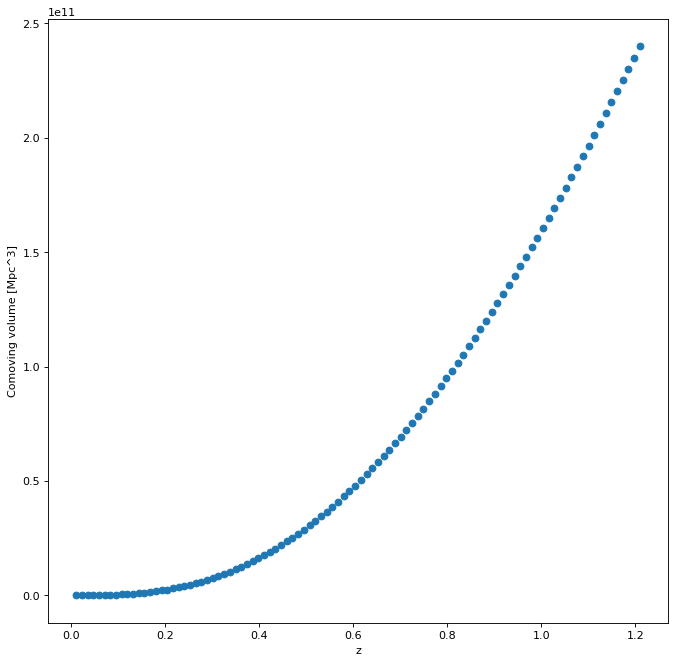

In [11]:
#Calculate Comoving Volume

comoving_volume = WMAP9.comoving_volume(bins_z)  #Give Volume in Mpc^3
comoving_volume_unbinned = WMAP9.comoving_volume(z)
#print(comoving_volume)
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bins_z, comoving_volume)
plt.xlabel('z')
plt.ylabel('Comoving volume [Mpc^3]')

A cell that has all the required TDE rates (in various units)

In [12]:
#TDE rates

tde = data['TDE_rate']
bin_sum_tde = [tde[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_tde_per_square_degree = np.array(bin_sum_tde)/survey_area
bin_sum_tde_all_sky = bin_sum_tde_per_square_degree*41253
bin_sum_tde_all_sky_cum = np.cumsum(bin_sum_tde_all_sky)
bin_sum_tde_per_vol = bin_sum_tde_all_sky/comoving_volume
bin_sum_tde_per_vol_cum = np.cumsum(bin_sum_tde_per_vol)

In [13]:
#TDE rate per square degree

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_per_square_degree))
# plt.xlabel('Redshift')
# plt.ylabel('TDE rate [deg^-2]')
# plt.title('TDE rate vs redshift')

# plt.show()

In [14]:
#TDE rate all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_all_sky))
# plt.xlabel('Redshift')
# plt.ylabel('TDE rate [All Sky - 42153deg^2]')
# plt.title('TDE rate vs redshift')

# plt.show()

In [15]:
#TDE rate all sky cumulutive

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_all_sky_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative TDE rate [All Sky - 42153deg^2]')
# plt.title('Cumulative TDE rate vs redshift')

# plt.show()

The visually important graph for TDE rates which are off by a factor of 10

In [16]:
#TDE rate all sky cumulutive as a LOG graph

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(np.array(bin_sum_tde_all_sky_cum)))
# plt.xlabel('Redshift')
# plt.ylabel('LOG Cumulative TDE rate [All Sky - 42153deg^2]')
# plt.title('LOG Cumulative TDE rate vs redshift')

# #plt.show()

In [17]:
#TDE rate per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_per_vol))
# plt.xlabel('Redshift')
# plt.ylabel('TDE rate [Mpc-3]')
# plt.title('TDE rate vs redshift')

# plt.show()

In [18]:
#TDE rate per Mpc^3 as a LOG graph

# bin_sum_tde_per_vol_cum_log = bin_sum_tde_per_vol_cum.value
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(bin_sum_tde_per_vol.value))
# plt.xlabel('Redshift')
# plt.ylabel('LOG TDE rate [Mpc-3]')
# plt.title('LOG TDE rate vs redshift')

# plt.show()

In [19]:
#TDE rate per Mpc^3 cumulative

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_per_vol_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative TDE rate [Mpc-3]')
# plt.title('Cumulative TDE rate vs redshift')

# plt.show()

AWLDladsjjlsadjlidsajlidas

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\3287471805.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_tde_all_sky/2))))


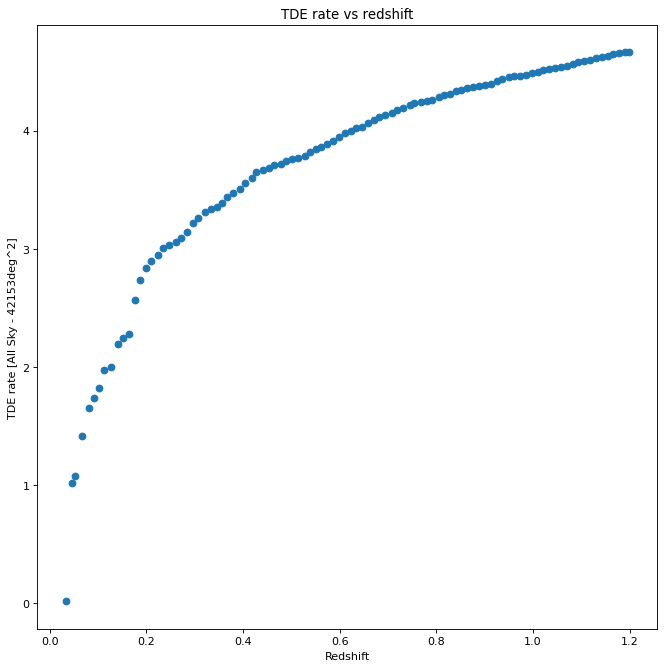

In [20]:
#Cumulative TDE rate all sky - 20,000deg^2 for LSST LOG

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_tde_all_sky/2))))
plt.xlabel('Redshift')
plt.ylabel('TDE rate [All Sky - 42153deg^2]')
plt.title('TDE rate vs redshift')

plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\3312074129.py:4: RuntimeWarning: divide by zero encountered in log
  bin_sum_tde_per_vol_cum_log = [np.log(x) for x in bin_sum_tde_per_vol_cum.value]
C:\Users\steve\AppData\Local\Temp\ipykernel_19492\3312074129.py:6: RuntimeWarning: divide by zero encountered in log10
  bin_sum_tde_per_vol_cum_log = np.log10(bin_sum_tde_per_vol_cum.value)


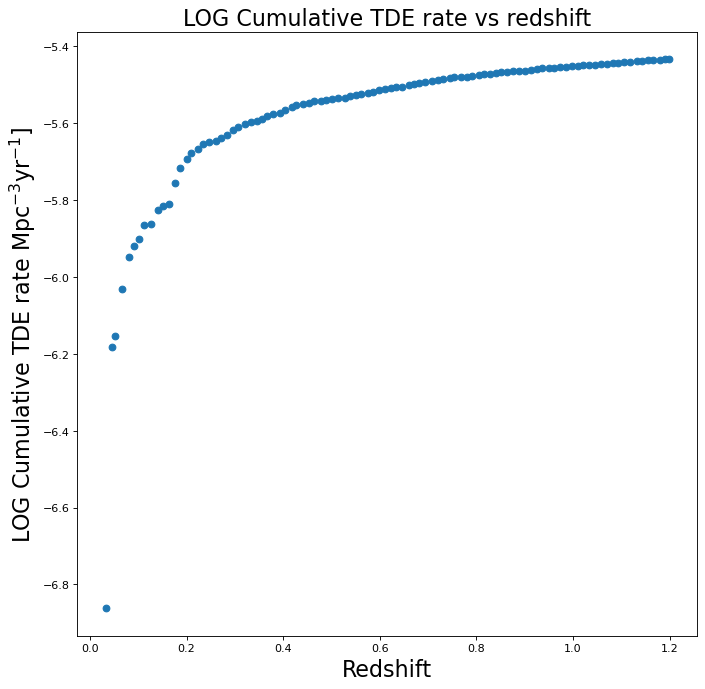

In [21]:
#TDE rate per Mpc^3 cumulative as a LOG graph
fontsize = 20
#print(bin_sum_tde_per_vol_cum)
bin_sum_tde_per_vol_cum_log = [np.log(x) for x in bin_sum_tde_per_vol_cum.value]
bin_means_z_log = [np.log(x) for x in bin_means_z]
bin_sum_tde_per_vol_cum_log = np.log10(bin_sum_tde_per_vol_cum.value)
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, bin_sum_tde_per_vol_cum_log)
plt.xlabel('Redshift', fontdict={'fontsize': fontsize})
plt.ylabel('LOG Cumulative TDE rate Mpc$^{-3}$yr$^{-1}$]', fontdict={'fontsize': fontsize})
plt.title('LOG Cumulative TDE rate vs redshift',fontdict={'fontsize': fontsize})

plt.show()

In [22]:
Luminosity = data['Keck_DEIMOS_DEEP_B_Absolute']
# print(Luminosity)

In [23]:
bin_Lum = [Luminosity[digitized_z == i].sum() for i in range(0, len(bins_z))]
# print(bin_Lum)
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_Lum))
# plt.xlabel('Redshift')
# plt.ylabel('Luminosity')
# plt.title('Luminosity vs redshift')

The code to create SN rates assuming const rate per sm

In [24]:
#Supernova rates assuming const per stellar mass
h = 0.7
sm = data['supernovae_rate_assuming_const_rate_per_stellar_mass'] 
bin_sum_sm = [sm[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_sm_per_square_degree = np.array(bin_sum_sm)/survey_area
bin_sum_sm_all_sky = bin_sum_sm_per_square_degree*41253
bin_sum_sm_all_sky_cum = np.cumsum(bin_sum_sm_all_sky)
bin_sum_sm_per_vol = bin_sum_sm_all_sky/comoving_volume
bin_sum_sm_per_vol_cum = np.cumsum(bin_sum_sm_per_vol)

In [25]:
#Supernova rate assuming constant rate per stellar mass per square degree

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sm_per_square_degree))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [deg^-2]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\2882700854.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_sm_all_sky/2))))


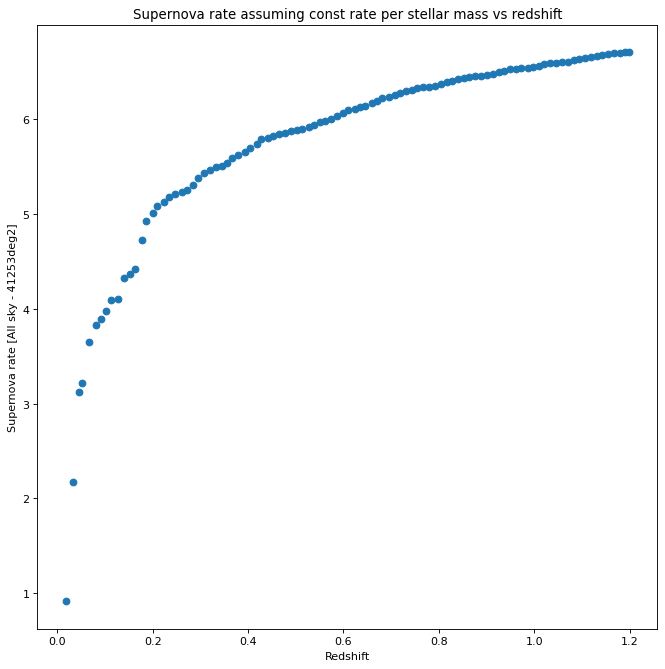

In [26]:
#Cumulative Supernova rate assuming const rate per stellar mass all sky LOG

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_sm_all_sky/2))))
plt.xlabel('Redshift')
plt.ylabel('Supernova rate [All sky - 41253deg2]')
plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

plt.show()

In [27]:
#Supernova rate assuming const rate per stellar mass all sky as a LOG GRAPH

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z,np.log10(np.array(bin_sum_sm_all_sky)))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [All sky - 41253deg2]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

In [28]:
#Cumulutive Supernova rate assuming const rate per stellar mass all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, (np.array(bin_sum_sm_all_sky_cum)))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('Cumulative Supernova assuming const rate rate per stellar mass vs redshift')

#plt.show()

In [29]:
#Cumulutive Supernova rate assuming const rate per stellar mass all sky as a LOG GRAPPH
# bin_sum_sm_all_sky_cum_log = [np.log10(x) for x in bin_sum_sm_all_sky_cum]
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, bin_sum_sm_all_sky_cum_log)
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('Cumulative Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

In [30]:
#Supernova rate assuming const rate per stellar mass per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sm_per_vol))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [Mpc^-3]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\949721854.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sm_per_vol_cum)))


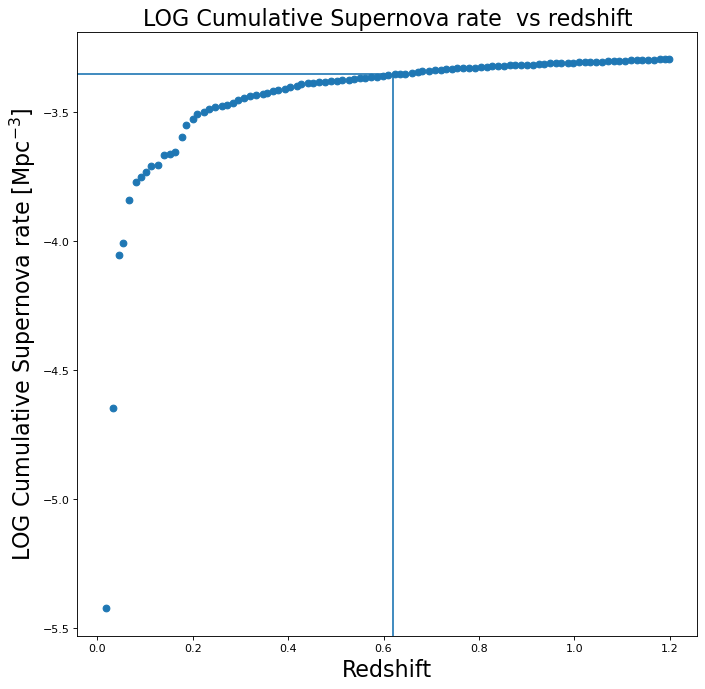

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\949721854.py:11: RuntimeWarning: divide by zero encountered in log10
  np.interp(0.62, bin_means_z,  np.log10(np.array(bin_sum_sm_per_vol_cum)))


-3.3557136316773444

In [31]:
#Cumulutive Supernova rate assuming const rate per stellar mass per Mpc^3
fontsize = 20
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sm_per_vol_cum)))
plt.xlabel('Redshift', fontdict={'fontsize': fontsize})
plt.ylabel('LOG Cumulative Supernova rate [Mpc$^{-3}$]', fontdict={'fontsize': fontsize})
plt.title('LOG Cumulative Supernova rate  vs redshift', fontdict={'fontsize': fontsize})
plt.axvline(x =0.62, ymin = 0, ymax = 0.93)
plt.axhline(y = -3.3557136316773444, xmin = 0.0, xmax = 0.5)
plt.show()
np.interp(0.62, bin_means_z,  np.log10(np.array(bin_sum_sm_per_vol_cum)))


Code to create SN rates assuming const rate per SFR

In [32]:
#Supernova rates assuming const rate per star formation rate

sfr = data['supernovae_rate_assuming_const_rate_per_star_formation_rate']
bin_sum_sfr = [sfr[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_sfr_per_square_degree = np.array(bin_sum_sfr)/survey_area
bin_sum_sfr_all_sky = bin_sum_sfr_per_square_degree*41253
bin_sum_sfr_all_sky_cum = np.cumsum(bin_sum_sfr_all_sky)
bin_sum_sfr_per_vol = bin_sum_sfr_all_sky/comoving_volume
bin_sum_sfr_per_vol_cum = np.cumsum(bin_sum_sfr_per_vol)

In [33]:
#Supernova rates assuming const rate per star formation rate per square degree

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_per_square_degree))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [deg^-2]')
# plt.title('Supernova rate assuming const rate per star formation rate vs redshift')

#plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\2000194785.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_sfr_all_sky/2))))


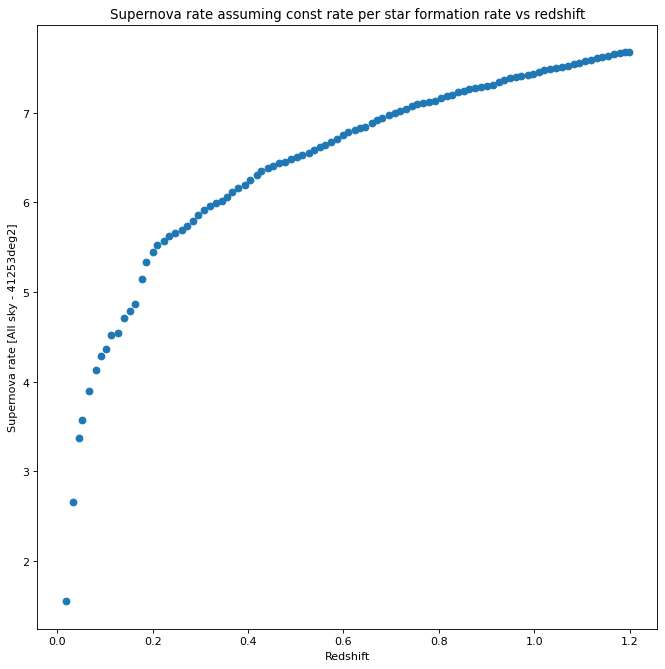

In [34]:
#Cumulative Supernova rates assuming const rate per star formation rate all sky - 20,000deg^2 for LSST LOG

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_sfr_all_sky/2))))
plt.xlabel('Redshift')
plt.ylabel('Supernova rate [All sky - 41253deg2]')
plt.title('Supernova rate assuming const rate per star formation rate vs redshift')

plt.show()

In [35]:
#Cumulutive Supernova rates assuming const rate per star formation rate all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_all_sky_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('Cumulative Supernova assuming const rate rate per star formation rate vs redshift')

#plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\74371154.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_all_sky_cum/2)))


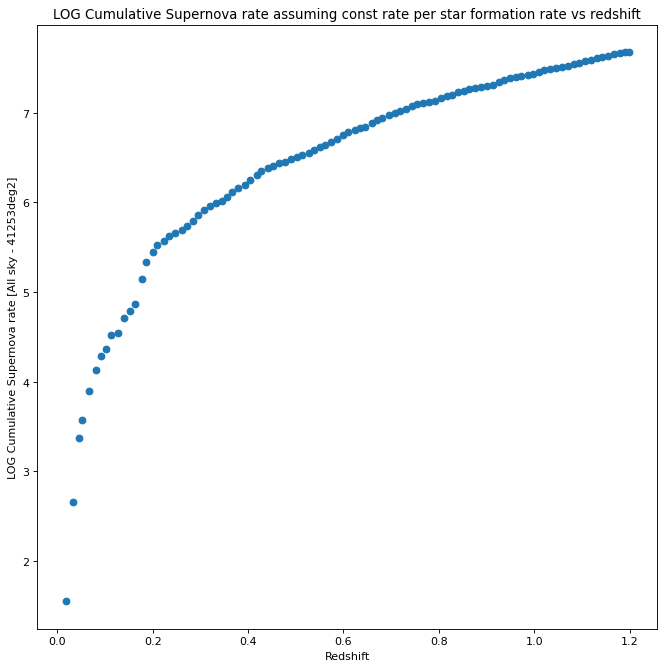

In [36]:
#Cumulutive Supernova rates assuming const rate per star formation rate all sky as a LOG GRAPH

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_all_sky_cum/2)))
plt.xlabel('Redshift')
plt.ylabel('LOG Cumulative Supernova rate [All sky - 41253deg2]')
plt.title('LOG Cumulative Supernova rate assuming const rate per star formation rate vs redshift')

plt.show()

In [37]:
#Supernova rates assuming const rate per star formation rate per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_per_vol)))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [Mpc^-3]')
# plt.title('Supernova rate assuming const rate per star formation rate vs redshift')

# plt.show()

In [38]:
#Cumulutive Supernova rates assuming const rate per star formation rate per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_per_vol_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [Mpc^-3]')
# plt.title('Cumulative Supernova rate assuming const rate per star formation rate vs redshift')

plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\4231373826.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_per_vol_cum)))


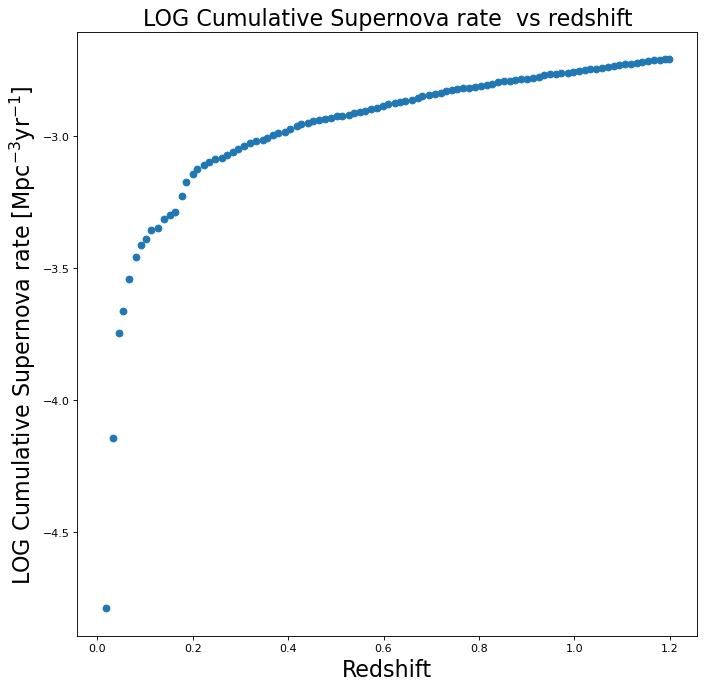

In [39]:
#Cumulutive Supernova rates assuming const rate per star formation rate per Mpc^3 as a LOG GRAPH

fontsize = 20
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_per_vol_cum)))
plt.xlabel('Redshift', fontdict={'fontsize': fontsize})
plt.ylabel('LOG Cumulative Supernova rate [Mpc$^{-3}$yr$^{-1}$]', fontdict={'fontsize': fontsize})
plt.title('LOG Cumulative Supernova rate  vs redshift', fontdict={'fontsize': fontsize})

plt.show()

Code to create Stellar Mass Function plots for Millenium at Z=0, Z=0.1, and Z=1

In [40]:
h = 0.73

This first graph needs to be corrected for feedback etc

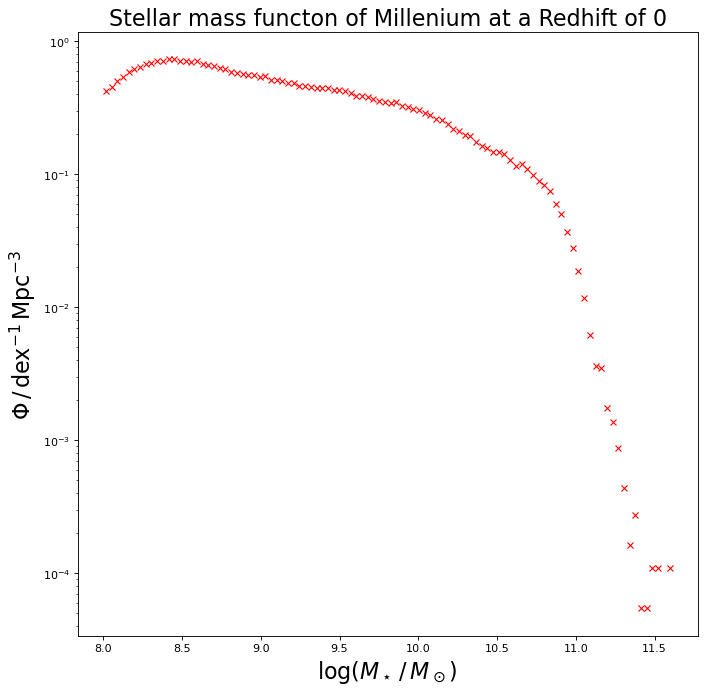

In [41]:
import numpy as np
import matplotlib.pyplot as plt
fontsize = 20
Co_Vol_at_z1 = np.interp(0.000000000001,bins_z,comoving_volume)

M     = data_0['Total_Stellar_Mass']*10**10         #Read stellar masses in Msun
#total_sm = [M[digitized_z == i].sum() for i in range(1, len(bins_z))]
#sm = M[1:30]
#print(sm)
#print(total_sm)
logM  = np.log10(M)                     #Take logarithm
nbins = 100                              #Number of bins to divide data into
V     = Co_Vol_at_z1                           #Survey volume in Mpc3
Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
dM    = edg[1] - edg[0]  #Bin size
Max   = edg[0:-1] + dM/2.               #Mass axis
Phi   = Phi / V / dM                    #Normalize to volume and bin size
plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$', fontdict={'fontsize': fontsize})
plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$', fontdict={'fontsize': fontsize})
plt.title(r'Stellar mass functon of Millenium at a Redhift of 0', fontdict={'fontsize': fontsize})
plt.plot(Max,Phi,'rx')

In [42]:
# import numpy as np
# import matplotlib.pyplot as plt

# Co_Vol_at_z2 = np.interp(0.0000000000000001,bins_z,comoving_volume)
# M= data_0['Total_Stellar_Mass']*10**10   #Read stellar masses in Msun
# logM  = np.log10(M)                     #Take logarithm
# nbins = 100                              #Number of bins to divide data into
# V     = Co_Vol_at_z2                            #Survey volume in Mpc3
# Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
# dM    = edg[1] - edg[0]                 #Bin size
# Max   = edg[0:-1] + dM/2.               #Mass axis
# Phi   = Phi / V / dM                    #Normalize to volume and bin size
# plt.figure(figsize=(10, 10), dpi=80)
# plt.clf()
# plt.yscale('log')
# plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
# plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$')
# plt.plot(Max,Phi,ls='dashed')
# print(edg[1])

In [43]:
# Co_Vol_at_z3 = np.interp(1,bins_z,comoving_volume)

# M     = data_0['Total_Stellar_Mass']*10**10         #Read stellar masses in Msun
# logM  = np.log10(M)                     #Take logarithm
# nbins = 100                              #Number of bins to divide data into
# V     = Co_Vol_at_z3                           #Survey volume in Mpc3
# Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
# dM    = edg[1] - edg[0]                 #Bin size
# Max   = edg[0:-1] + dM/2.               #Mass axis
# Phi   = Phi / V / dM                    #Normalize to volume and bin size
# plt.figure(figsize=(10, 10), dpi=80)
# plt.clf()
# plt.yscale('log')
# plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
# plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$')
# plt.plot(Max,Phi,ls='dashed')

Attemp to plot of SFR density against Redshift

In [44]:
TOTAL_SFR_RATE = data_0['Total_Star_Formation_Rate']
bin_sum_totalsfr = [TOTAL_SFR_RATE[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_totalsfr_per_square_degree = np.array(bin_sum_sfr)/survey_area
bin_sum_totalsfr_all_sky = bin_sum_totalsfr_per_square_degree*41253
bin_sum_totalsfr_all_sky_cum = np.cumsum(bin_sum_totalsfr_all_sky)
bin_sum_totalsfr_per_vol = bin_sum_totalsfr_all_sky/comoving_volume
bin_sum_totalsfr_per_vol_cum = np.cumsum(bin_sum_totalsfr_per_vol)

In [45]:
#print(bin_sum_totalsfr_per_vol)

This plot's vertical axis should be centred around -2 - our graph is shifted vertically lower - why?

In [46]:
#Plotting SFR against Z
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(bin_sum_totalsfr_per_vol_cum.value))
# plt.xlabel('')
# plt.ylabel('')
# plt.title('')

# plt.show()

Improving our TDE Rate Equation 

In the following cell i will use Van Velzen (2018) method of summing the 1/Vmax in bins of luminosity in order to find a luminosity function of TDE's.
We have to use the flux limit of the survey.

In [47]:
lum = data_0['Keck_DEIMOS_DEEP_B_Apparent']
print(Luminosity)

82341    -16.4526
121562   -16.0337
121560   -15.8725
121564   -16.4875
121561   -16.5862
           ...   
42670    -20.2534
42744    -21.8602
42803    -21.3400
42689    -18.6985
42697    -20.4798
Name: Keck_DEIMOS_DEEP_B_Absolute, Length: 608374, dtype: float64


In [48]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(z, lum)
# plt.xlabel('')
# plt.ylabel('')
# plt.title('')
# plt.xlim([0, 0.1])
# plt.ylim([15, 25])

In [49]:
bins_lum = np.linspace(np.min(lum), np.max(lum), no_of_bins)
binsize = (np.max(lum) - np.min(lum))/no_of_bins
digitized_lum = np.digitize(lum, bins_lum) #creates mask for each bin
bin_means_lum = [lum[digitized_lum == i].mean() for i in range(0, len(bins_lum))]

In [50]:
print(len(bin_means_lum)) #want len of Vmax to match this so 

100


In [51]:
A = RA * DEC
zmax = 0.1
VZmax = np.interp(1, bin_means_z, comoving_volume)
Tau = 60*60 ## What is the correct value for survey time?



Vmax = VZmax * A * Tau
print(Vmax)

82341     1.116749e+14
121562    2.905946e+14
121560    9.025153e+13
121564    6.276206e+14
121561    1.075936e+12
              ...     
42670     9.510324e+13
42744     9.771779e+13
42803     9.093581e+13
42689     9.258810e+13
42697     9.680397e+13
Length: 608374, dtype: float64


In [52]:
bin_sum_Vmax = [lum[digitized_lum == i].sum() for i in range(0, len(bins_lum))]
#print(bin_sum_Vmax)
yy = bin_sum_Vmax[1:]
#print(xx)
yyy = bin_sum_Vmax[1:30]
#print(xxx)
xxx = bin_means_lum[1:30]
#print(xxx)
Lum_bin = [i*4*10**26 for i in xxx]
# bin_sum_Vmax.sort()
#print(yyy)
# for num in xxx:
#     y = 1/num
#     print(y)

In [53]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(Lum_bin, yyy)
# plt.xlabel('Lum')
# plt.ylabel('1/Vmax')
# plt.title('')

# plt.show()

Following graph is 1/Vmax against bins of Lum

In [54]:
y = [1 / y for y in yyy]

C:\Users\steve\AppData\Local\Temp\ipykernel_19492\2515035377.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  y = [1 / y for y in yyy]


In [55]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(Lum_bin, y)
# plt.xlabel('Lum')
# plt.ylabel('1/Vmax')
# plt.title('')

# plt.show()

In [56]:
#Summed all of the Lums

# bin_sum_Vmax = [lum[digitized_lum == i].sum() for i in range(0, len(bins_lum))]
# #print(bin_sum_Vmax)
# bin_sum_Vmax.sort()
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_lum, bin_sum_Vmax)
# plt.xlabel('')
# plt.ylabel('')
# plt.title('')

# plt.show()

From here, we want to plot Van Velzen(2018) method and find the well fitted power law/estimation which should give us our corrected value of 10^-4 instead of our modelled value of 10^-5

In [57]:
# # l = Lum **1*10**24
# for i in Lum:
#     x1 = i*1*10**24
#     print(x1)
# l = [ i*1*10**24 for i in Lum]
# print(l)

In [58]:
#For help y = [1 / y for y in yyy]
#print(l)
Tde = [2*10**-7*(p/1*10**37)**(-1.5) for p in Lum_bin]
#tde = np.array(Tde)
#print(tde)
#print(Tde)
denominator = [np.log10(x) for x in Lum_bin]  
#ll = np.array(l)
#lll = l*1*10**26 ##### Want to divide Tde by denominator but cant because need to iterator through denminator to log every value inside 
#print(lll)
#print(denominator)
#d = np.array(denominator)
#print(np.log10(l[0])) # matches first log value so works 
# for j in denominator:
#     print(j)
# for j in Tde:
#     print(j)
n = [i / np.log10(j) for i, j in zip(Tde, denominator)]
print(n)
#type(denominator)
#type(Tde)
#x = [i/denominator for i in Tde]
    #print(x)
#     Lum_bin = [lum[digitized_lum == i].sum() for i in range(0, len(bins_z))]
#     print(Lum_bin)

[9.255276917436503e-105, 8.4391627245472e-105, 7.833406341272129e-105, 7.274156078652855e-105, 6.771111987308349e-105, 6.323258832063906e-105, 5.924443649180318e-105, 5.572353690131885e-105, 5.249828694350847e-105, 4.961679247495338e-105, 4.6988420032363895e-105, 4.4582316192357885e-105, 4.2386395061977065e-105, 4.037020157014139e-105, 3.849396329536363e-105, 3.66964906074989e-105, 3.5066398612259696e-105, 3.360771914165383e-105, 3.2330584293508626e-105, 3.10947200195448e-105, 2.9853856360691203e-105, 2.8160535694102075e-105, 2.73494567163188e-105, 2.67377427594621e-105, nan, nan, nan, nan, nan]


Attempt to plot their log fit function onto my graph to see if they match

In [59]:
# plt.figure(figsize=(10, 10), dpi=80)
# n_bin = [lum[digitized_lum == i].sum() for i in range(0, len(bins_lum))]
# #print(x)
# print(tde)
# #plt.scatter(Lum_bin, y)
# plt.scatter(Lum_bin, n)
# plt.xlabel('Lum bin')
# plt.ylabel('TDE')
# plt.title('')

# plt.show()